In [4]:
from snowflake_helper.snowflake_helper import SnowflakeHelper

In [5]:
from BSG_utils import product_visualizer
import pandas as pd
import ast

In [24]:
snowflake_manager = SnowflakeHelper()
QUERY = 'select * from PLAYGROUNDS.ADRIANCAMPOY.ARTICLES_INFO;'
data = snowflake_manager.load_data_from_query(QUERY)

In [8]:
closest_items = pd.read_pickle('gs://bsg-image-recommendation/ALBEF/ALBEF_closest_articles_per_product.pickle')

In [80]:
closest_items.head()

,id,closest_items,distances
0,PM-36502,"['PM-30265', 'PM-32376', 'PM-33372', 'PM-36295...","[1.674264669418335, 1.693128228187561, 1.99701..."
1,PM-29405,"['PM-33493', 'PM-27365', 'PM-30322', 'PM-33118...","[2.5662477016448975, 2.759308338165283, 2.8208..."
2,PM-8086,"['722208', '778539', 'PM-5429', 'PM-12569', 'P...","[2.62333083152771, 2.6731600761413574, 2.73592..."
3,790625,"['PM-4333', 'PM-4788', 'PM-38170', '715687', '...","[2.77174711227417, 2.9272427558898926, 2.93100..."
4,PM-7983,"['PM-5085', 'PM-21604', '829698', 'PM-8268', '...","[4.263756275177002, 4.4959211349487305, 4.9430..."


In [81]:
data.keys()

Index(['display_product_id', 'product_no', 'country_code', 'title',
       'description', 'product_group', 'product_group_level_1_description',
       'product_group_level_2_description',
       'product_group_level_3_description', 'collection', 'brand', 'gender',
       'brand_segment', 'base_colour', 'average_price', 'average_cost_sek',
       'average_gp2_sek', 'quantity_sold', 'images_link', 'max_age',
       'min_age'],
      dtype='object')

In [82]:
data = data[data['country_code']=='SE']

In [121]:
article_to_get_recommendations_from = '813449'

main_article_data = data[data['product_no']==article_to_get_recommendations_from]
recommended_products = closest_items[closest_items['id']==article_to_get_recommendations_from]['closest_items'].tolist()
recommended_products = ast.literal_eval(recommended_products[0])
article_numbers_data = data[data['product_no'].isin(recommended_products)]

In [124]:
article_numbers_data['scoring'] = 0

# Checking for same category
if main_article_data['product_group_level_3_description'] is not None:
    article_numbers_data.loc[article_numbers_data['product_group_level_3_description'].isin(
        main_article_data['product_group_level_3_description'].tolist()), 'scoring'] += 2

if main_article_data['product_group_level_2_description'] is not None:
    article_numbers_data.loc[article_numbers_data['product_group_level_2_description'].isin(
        main_article_data['product_group_level_2_description'].tolist()), 'scoring'] += 1
    
# Checking for same brand
article_numbers_data.loc[article_numbers_data['brand'].isin(main_article_data['brand'].tolist()), 'scoring'] += 1

#Checking for same colour
article_numbers_data.loc[article_numbers_data['base_colour'].isin(main_article_data['base_colour'].tolist()), 'scoring'] += 0.5


# Scoring for the distribution of sizes in stock. Distribution of sizes should be or maybe shouldn't be different to the 
#sizes that we have now. Probably penalization if there is low stock.

# We could take this data and see which product they click on. Trying to predict the next item (these factors should be trained)
# List wise loss. 
# "estimated value of click/ estimated GP2/GP3 of the click"

# Session based similar items.

# Priority: Simplicity in design. 

# check time to compute closest items. 

article_numbers_data = article_numbers_data.sort_values(by='scoring', ascending=False)


/var/folders/2n/ct3fgq516b158h6zx5s586640000gn/T/ipykernel_7676/3624177314.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_numbers_data['scoring'] = 0


In [125]:
recommended_products = article_numbers_data['product_no'].tolist()
article_titles = article_numbers_data['title'].tolist()
article_images = article_numbers_data['images_link'].tolist()
avg_prices = article_numbers_data['average_price'].tolist()
article_brands = article_numbers_data['brand'].tolist()

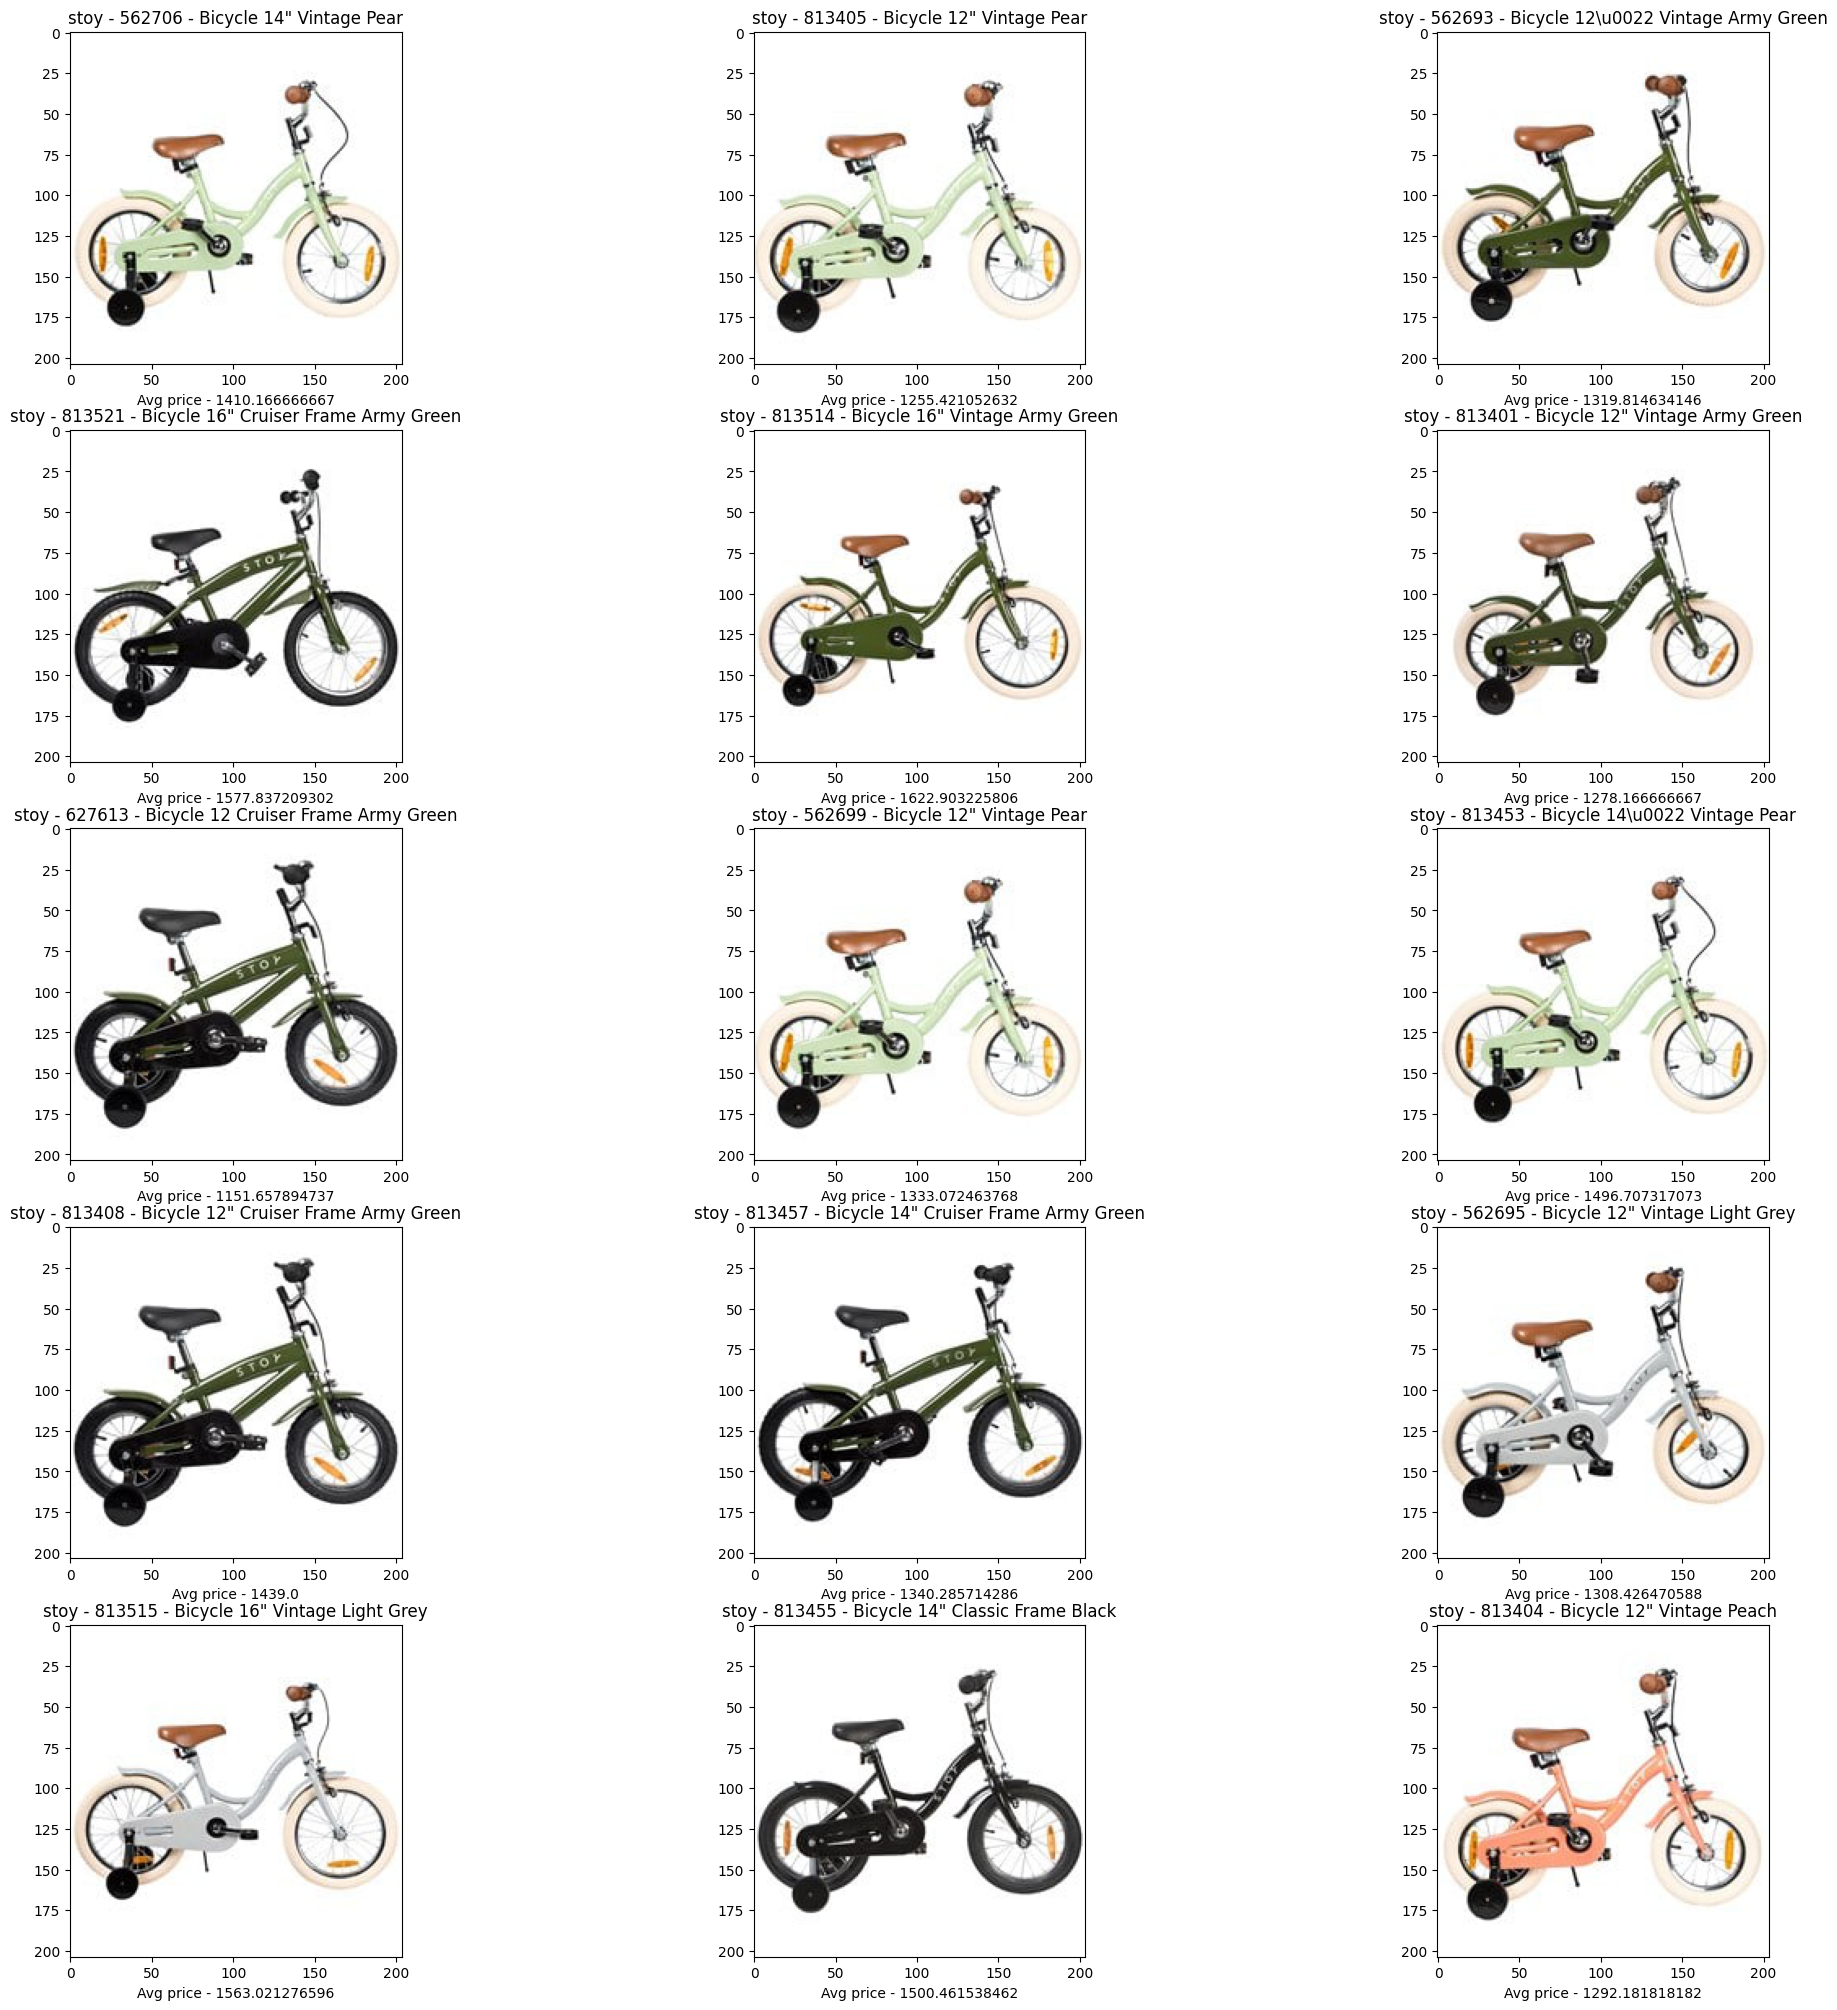

In [126]:
product_visualizer(article_numbers = recommended_products, article_brands = article_brands, article_titles = article_titles, article_images = article_images, avg_prices=avg_prices, n_rows=5, n_cols=3)
